#Machine Learning 2 Exam

###Sign Language Classification Problem

Authors : Claudio Del Gaizo S4696649, Thomas Campagnolo S5343274

Dataset :  https://drive.google.com/drive/folders/17sFFpdLQ6s18_Ux0AbW66ZRAk2lLZXUU?usp=sharing

Descrizione dataset

Lista modelli di classificazioni usati  e presenti qua



In [32]:
# Mount drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!nvidia-smi

Tue Jul  4 13:10:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
# import libraries
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
import time
from sklearn.metrics import confusion_matrix



In [35]:
# Change only 'path' variable to your folder containing the dataset
path = '/content/drive/MyDrive/Sign_dataset/'

file_train = path + 'sign_mnist_train/sign_mnist_train.csv'
file_test = path + 'sign_mnist_test/sign_mnist_test.csv'

In [36]:
# information about data structure
df_train = pd.read_csv(file_train)
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Loading Data

In [58]:
# create an ordered training subset composed by "nl" samples for each class and an ordered test subset composed by "nt" samples for each class

# flag to switch subdataset's dimensions
flag = 1

if(flag == 0):
  nl = 300    # number of training samples
  nt = 76     # number of testing samples
elif(flag ==1):
  nl = 500
  nt = 100

def load_data(path, n):
  df = pd.read_csv(path)

  for i in range(0,25):
    if (i == 9 or i == 25):
      # case 9 = 'J' & 25 = 'Z'
      continue
    else:
      temp = df.loc[df['label'] == i] # find samples belonging to i-th class

      temp_sub = temp.drop('label', axis=1).to_numpy()

      if (i == 0):
        # create the sample matrices 'X' about the images and the sample column vectors 'Y' about the labels
        X = temp_sub[range(0,n),:]
        Y = i*np.ones(n)
      else:
        if(i < 9):
          # concatenate and append the subsequent matrices and vectors to the previous ones
          X = np.concatenate((X,temp_sub[range(0,n),:]),axis=0)
          Y = np.append(Y,i*np.ones(n))
        else:
          # concatenate and append the subsequent matrices and vectors to the previous ones
          X = np.concatenate((X,temp_sub[range(0,n),:]),axis=0)
          Y = np.append(Y,(i-1)*np.ones(n)) # 'i-1' to avoid the discontinuities between the labels concerning the 'J' (9)

  return X, Y

# load data
X_train, Y_train = load_data(file_train, nl)
X_test, Y_test = load_data(file_test,nt)

print('x_train subset shape : ', X_train.shape)
print('y_train subset shape : ',Y_train.shape)
print('x_test subset shape : ',X_test.shape)
print('y_test subset shape : ',Y_test.shape)

x_train subset shape :  (12000, 784)
y_train subset shape :  (12000,)
x_test subset shape :  (2400, 784)
y_test subset shape :  (2400,)


In [59]:
# Run to Shuffle the training subset created
train = np.c_[X_train, Y_train]

shuffled_train = shuffle(train, random_state=0) # shuffle operation

X_train = shuffled_train[:, 0:784] # X_train shuffled matrix
Y_train = shuffled_train[:, 784] # Y_train shuffled vector

# Preprocessing Data & Visualization

In [60]:
# Normalize data
scalerX = preprocessing.MinMaxScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

In [61]:
# create class names associated to labels removing 'J' and 'Z'
class_names = list(string.ascii_lowercase[:26].replace('j', '').replace('z', ''))
print("class: ", class_names)

class:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


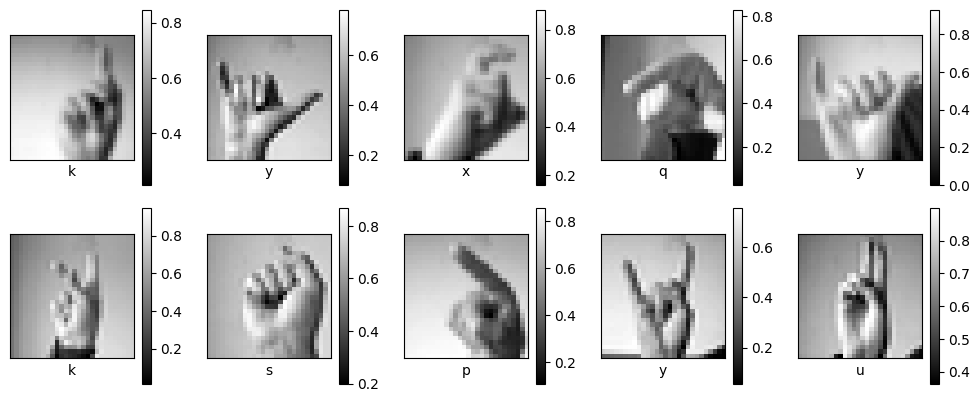

In [62]:
# plot 10 random images with related labels from training subset
plt.figure(figsize=(10, 10))
delta = 0
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  tmp = np.reshape(X_train[i+delta,:], (28,28))
  plt.imshow(tmp, cmap = 'gray')
  plt.colorbar()

  plt.xlabel(class_names[int((Y_train)[i+delta])])
plt.tight_layout()
plt.show()

# Training SVC Model *(linear kernel)*

In [65]:
## Support Vector Classification (SVC) with linear kernel
from sklearn.model_selection import GridSearchCV # optimal hyperparameters research algorithm
from sklearn.svm import SVC


start_time = time.time() #get the start time

grid = {'C': np.logspace(-4,3,5), # log scale : start point (10^), end point (10^), number of points
        'kernel': ['linear']}

# initialize GridSearchCV obect to research for optimal hyperparameters
MS = GridSearchCV(estimator = SVC(),
                  param_grid = grid,
                  scoring = 'accuracy', # balanced subset
                  cv = 10,              # percentage of samples from training set used for validation
                  verbose = 1)

# execute the hyperparameters research
H = MS.fit(X_train,Y_train)

print('Logspace points C: ', H.best_params_['C'])
print('Kernel: ', H.best_params_['kernel'])

# give the obtained optimal hyperparameters to the model
M = SVC(C = H.best_params_['C'],
        kernel = H.best_params_['kernel'])

# Train our Classifier using the training subset
M.fit(X_train,Y_train)


end_time = time.time()
elapsed_time = end_time - start_time
print("execution time : ", elapsed_time, "s" )

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Logspace points C:  0.31622776601683794
Kernel:  linear
execution time :  1263.0278415679932 s


# Prediction SVC model *(linear kernel)*

<Figure size 640x480 with 0 Axes>

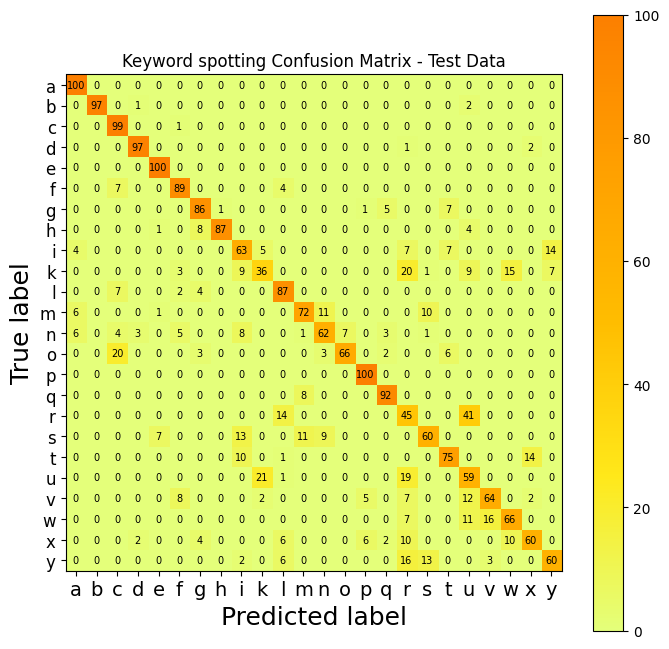

The accuracy is:  75.92 %


In [66]:
#  Make predictions on test subset

YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)
# print(conf_matrix)

accuracy = 0.0
# Visualize Confusion Matrix & Performances

plt.clf()

plt.figure(figsize = (8,8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)

classNames = class_names

plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, fontsize=14)
plt.yticks(tick_marks, classNames, fontsize=12)
plt.colorbar()

for i in range(24):
    for j in range(24):
        plt.text(j,i,str(conf_matrix[i][j]), fontsize=7, horizontalalignment='center', verticalalignment='center')
        if i == j:
          # accuracy computation
          accuracy = (accuracy + conf_matrix[i][j])

plt.show()

accuracy = round((accuracy/(nt*len(class_names)))*100,2) # nt * 24

print('The accuracy is: ', accuracy, '%')



# Training SVC Model *(Gaussian kernel)*

In [54]:
## Support Vector Classification (SVC) with Gaussian (rbf) kernel   --> top performance

from sklearn.model_selection import GridSearchCV # optimal hyperparameters research algorithm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


start_time = time.time() #get the start time

grid = {'C': np.logspace(-4,3,5), # log scale: start point (10^), end point (10^), number of points,
        'kernel': ['rbf']}        # gaussian kernel


# initialize GridSearchCV obect to research for optimal hyperparameters
MS = GridSearchCV(estimator = SVC(),
                  param_grid = grid,
                  scoring = 'accuracy', # balanced dataset
                  cv = 10,              # percentage of samples from training set used for validation
                  verbose = 1)

# execute the hyperparameters research
H = MS.fit(X_train,Y_train)

print('Logspace points C: ', H.best_params_['C'])
print('Kernel: ', H.best_params_['kernel'])


# give the obtained optimal hyperparameters to the model
M = SVC(C = H.best_params_['C'],
        kernel = H.best_params_['kernel'])

# Train our Classifier using the training subset
M.fit(X_train,Y_train)


end_time = time.time()
elapsed_time = end_time - start_time
print("execution time : ", elapsed_time, "s" )




Fitting 10 folds for each of 5 candidates, totalling 50 fits
Logspace points C:  17.78279410038923
Kernel:  rbf
execution time :  882.8981997966766 s


# Prediction SVC model *(Gaussian kernel)*

<Figure size 640x480 with 0 Axes>

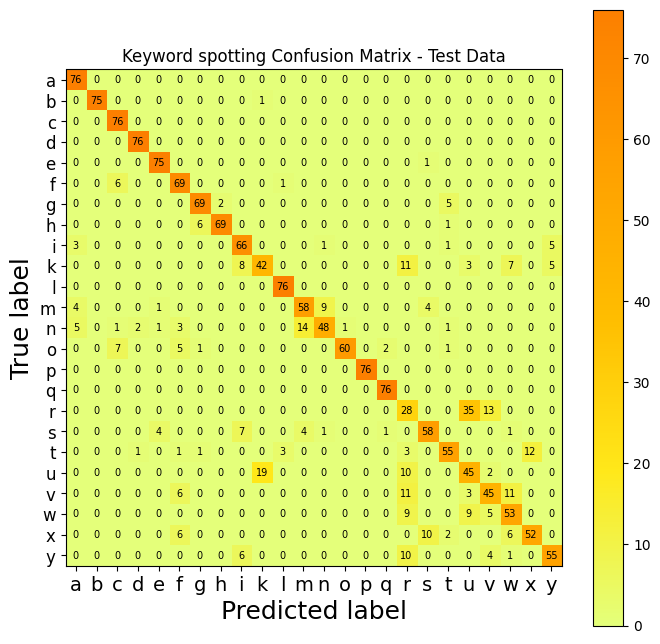

The accuracy is:  81.03


In [55]:
#  Make predictions on test subset
YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)
# print(conf_matrix)

accuracy = 0.0

# Visualize Confusion Matrix & Performances
plt.clf()

plt.figure(figsize = (8,8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)

classNames = class_names
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, fontsize=14)
plt.yticks(tick_marks, classNames, fontsize=12)
plt.colorbar()#io

for i in range(24):
    for j in range(24):
        plt.text(j,i,str(conf_matrix[i][j]), fontsize=7, horizontalalignment='center', verticalalignment='center') #così plotto in modo decente
        if i == j:
          # accuracy computation
          accuracy = (accuracy + conf_matrix[i][j])

plt.show()

accuracy = round((accuracy/(nt*len(class_names)))*100,2) # nt * 24

print('The accuracy is: ', accuracy)

# Training LinearSVC Model

In [ ]:
#### Linear Support Vector Classification (LinearsSVC)

from sklearn.model_selection import GridSearchCV # optimal hyperparameters research algorithm
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

grid = {'C': np.logspace(-4,3,5)} # log scale : start point (10^), end point (10^), number of points

# other possible hyperparameters, default : 'l2' & 'squared_hinge'
#'penalty': ['l1', 'l2'],
#'loss': ['hinge', 'squared_hinge'],

MS = GridSearchCV(estimator = LinearSVC(),
                  param_grid = grid,
                  scoring = 'accuracy', # balanced subset
                  cv = 10,              # percentage of samples from training set used for validation
                  verbose = 1)

# execute the hyperparameters research
H = MS.fit(X_train,Y_train)


print('Logspace points C: ', H.best_params_['C'])

# give the obtained optimal hyperparameters to the model
M = LinearSVC(C = H.best_params_['C'])

#penalty = H.best_params_['penalty'],
#loss = H.best_params_['loss'],

# Train our Classifier using the training subset
M.fit(X_train,Y_train)

# Prediction LinearSVC model

In [ ]:
#  Make predictions on test subset
YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)
# print(conf_matrix)

accuracy = 0.0

# Visualize Confusion Matrix & Performances
plt.clf()

plt.figure(figsize = (8,8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)

classNames = class_names
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, fontsize=14)
plt.yticks(tick_marks, classNames, fontsize=12)
plt.colorbar()#io

for i in range(24):
    for j in range(24):
        plt.text(j,i,str(conf_matrix[i][j]), fontsize=7, horizontalalignment='center', verticalalignment='center')
        if i == j:
          # accuracy computation
          accuracy = (accuracy + conf_matrix[i][j])

plt.show()

accuracy = round((accuracy/(nt*len(class_names)))*100,2) # nt * 24

print('The accuracy is: ', accuracy)

# Training Random Forest Model

In [63]:
##  Random Forest Classification

from sklearn.ensemble import RandomForestClassifier

start_time = time.time() #get the start time

M = RandomForestClassifier(n_estimators = 1000) # no need of hyperparameters

M.fit(X_train,Y_train)


end_time = time.time()
elapsed_time = end_time - start_time
print("execution time : ", elapsed_time, "s" )


execution time :  238.09025931358337 s


# Prediction Random Forest model

<Figure size 640x480 with 0 Axes>

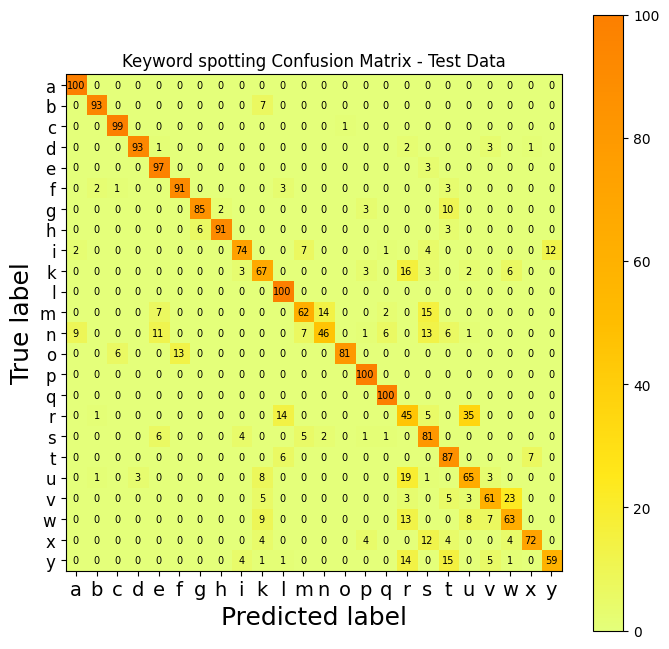

The accuracy is:  79.67


In [64]:
#  Make predictions on test subset
YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)
# print(conf_matrix)

accuracy = 0.0

# Visualize Confusion Matrix & Performances
plt.clf()

plt.figure(figsize = (8,8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)

classNames = class_names
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, fontsize=14)
plt.yticks(tick_marks, classNames, fontsize=12)
plt.colorbar()#io

for i in range(24):
    for j in range(24):
        plt.text(j,i,str(conf_matrix[i][j]), fontsize=7, horizontalalignment='center', verticalalignment='center')
        if i == j:
          # accuracy computation
          accuracy = (accuracy + conf_matrix[i][j])

plt.show()

accuracy = round((accuracy/(nt*len(class_names)))*100,2) # nt * 24

print('The accuracy is: ', accuracy)